In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution3D, MaxPooling3D, UpSampling3D, GlobalAveragePooling3D, Dense, Flatten, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import SGD, Adam, Nadam

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [29]:
import data
import random

vsize = np.asarray([32,32,32])

df_nodes = data.luna16_get_df_nodes() 
df_nodes = df_nodes[(df_nodes["diameter_mm"]>10)]

patient_ids = data.luna16_get_patient_ids()

X_nodules, diams = data.luna16_get_all_nodules(vsize, df_nodes)

def make_augmented(vsize, volume, X_nodules):
    idx = random.choice(range(len(X_nodules)))
    nodule = X_nodules[idx]
    # randomly flip or not flip each axis
    if random.choice([True, False]):
        nodule = nodule[::-1,:,:]
    if random.choice([True, False]):
        nodule = nodule[:,::-1,:]
    if random.choice([True, False]):
        nodule = nodule[:,:,::-1]
    mask = data.compose_make_mask(vsize, diam=diams[idx]+6, sigma=(diams[idx]+6)/8)
    volume_aug = data.compose_max2(volume, nodule, mask)
    return volume_aug

def sample_generator(vsize, patient_ids, X_nodules, diams):
    n = 0
    n_aug = 0

    central_mask = data.compose_make_mask(vsize, diam=6+6, sigma=(6+6)/8)
    
    while True:
        if n % 1000 == 0:
            try:
                pid = random.choice(patient_ids)
                image_ = data.luna16_get_image(pid)
                segmented_image_ = data.luna16_get_segmented_image(pid)

                image, segmented_image = image_, segmented_image_
                n+=1
                # segpack = np.packbits(segmented_image, axis=0)
                # info = data.luna16_get_info(pid)
            except Exception as e:
                #print(pid, repr(e))
                continue
            
        pos = np.asarray([ np.random.randint(k, image.shape[k] - vsize[k]) for k in range(3) ])
        segmented_volume = segmented_image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
        if np.count_nonzero(segmented_volume) == 0:
            continue
#         segpack_volume = segpack[pos[0]//8:(pos[0]+vsize[0])//8, pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
#         if np.count_nonzero(segpack_volume) == 0:
#            continue
        volume = image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
#         overlap = np.mean(segmented_volume)
#         density = np.mean(volume)
        central_density = np.mean((volume+1000) * central_mask) / np.mean(central_mask) - 1000
    
        is_augmented = False
        if central_density < -500 and np.random.choice([True, False]):
            volume = make_augmented(vsize, volume, X_nodules)
            is_augmented = True
            n_aug += 1
            
        n+=1

        yield volume, is_augmented
        
def batch_generator(vsize, patient_ids, X_nodules, diams):
    gen = sample_generator(vsize, patient_ids, X_nodules, diams)
    batch_size = 64
    while True:
        X = np.zeros((batch_size, 32,32,32,1), dtype=np.float32)
        y = np.zeros((batch_size, 2), dtype=np.int)
        for n in range(batch_size):
            volume, is_augmented = next(gen)
            X[n,:,:,:,0] = volume
            if is_augmented:
                y[n,1] = 1
            else:
                y[n,0] = 1
        X = (X - X_mean)/X_std
        X = scipy.ndimage.interpolation.zoom(X, (1, 0.5, 0.5, 0.5, 1), order=1)
        yield X, y

In [27]:
gen = batch_generator(vsize, patient_ids, X_nodules, diams)

In [20]:
X, y = next(gen)

In [23]:
X_big = []
for n in range(100):
    X, y = next(gen)
    X_big.append(X)

In [25]:
X_mean = np.mean(X_big)
X_std = np.std(X_big)
print(X_mean, X_std)

-378.9 475.913


In [6]:
np.save("/mnt/data/luna16/sets/synth_set_v1_20k_16x.npy", Xh)

In [2]:
vsize = (16, 16, 16)



def model3d(vsize, do_features=False):
    inputs = Input(vsize + (1,))
    sz = 48
    alpha = 1.5
    
    def conv3dparams(**replace_params):
        params = { 'activation':ELU(), 'border_mode':'valid', 'init': 'he_normal' }
        params.update(replace_params)
        return params

    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(inputs)
    x = BatchNormalization()(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = BatchNormalization()(x)

    x = Convolution3D(sz, 2, 2, 2, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 1, 1, 1, **conv3dparams(border_mode='same'))(x)
    x = BatchNormalization()(x)
    x = Convolution3D(2, 1, 1, 1, **conv3dparams(activation='linear', border_mode='same'))(x)
    if not do_features:
        x = Flatten()(x)
        x = Activation('softmax')(x)

    model = Model(input=inputs, output=x)

    return model



In [8]:
model = model3d(vsize)
print(model.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 16, 16, 16, 1) 0                                            
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 14, 14, 14, 48 1344        input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 14, 14, 14, 48 192         convolution3d_1[0][0]            
____________________________________________________________________________________________________
convolution3d_2 (Convolution3D)  (None, 12, 12, 12, 72 93384       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [9]:
#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')

batch_size=64

model.fit(
    Xh, 
    y, 
    batch_size=batch_size,
    nb_epoch=10,
    validation_split=0.1,
    verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True)])

KeyboardInterrupt: 

In [16]:

model.fit(
    Xh, 
    y, 
    batch_size=batch_size,
    nb_epoch=10,
    validation_split=0.1,
    verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True)])

KeyboardInterrupt: 

In [5]:
import data

/home/alex/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [6]:
pid = data.luna16_get_patient_ids()[0]

In [19]:
image = data.luna16_get_image(pid)

In [20]:
def preprocess(image):
    return (image - X_mean) / X_std

In [7]:
def preprocess2(image):
    image = np.clip(image, -1000, 100).astype(np.float32)
    return (image - np.mean(image)) / np.std(image)

In [21]:
model.save_weights('tmp.h5')

In [15]:
model2 = model3d((64,64,64), do_features=True)

In [16]:
# NOTE loading by_name=True fails, because the auto-generated layer names are counting up in keras for each layer class globally
# NOTE on the other hand plain loading works, since the missing top two layers don't have weights
model2.load_weights('tmp.h5')

In [17]:
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 64, 64, 64, 1) 0                                            
____________________________________________________________________________________________________
convolution3d_11 (Convolution3D) (None, 62, 62, 62, 48 1344        input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorm (None, 62, 62, 62, 48 192         convolution3d_11[0][0]           
____________________________________________________________________________________________________
convolution3d_12 (Convolution3D) (None, 60, 60, 60, 72 93384       batchnormalization_10[0][0]      
___________________________________________________________________________________________

In [33]:
def softmax(x):
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

In [24]:
pid = data.luna16_get_patient_ids()[0]

In [9]:
image = data.luna16_get_image(pid)
image = preprocess2(image)

In [10]:
import scipy.ndimage.interpolation
image_h =scipy.ndimage.interpolation.zoom(image, (0.5, 0.5, 0.5), order=1)

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [25]:
image_h.shape

(116, 180, 180)

In [12]:
def softmax_activations(x):
    r = x.reshape((-1,2))
    r_max = np.max(r, axis=-1)
    r_max = r_max[...,None]
    r_sum = np.sum(np.exp(r - r_max), axis=-1)
    r_sum = r_sum[...,None]
    p = np.exp(r - r_max) / r_sum
    p = p.reshape(x.shape)
    return p

In [22]:
def make_full_result(image):
    full_result = np.zeros((image.shape[0], image.shape[1], image.shape[2], 2))
    s = 49
    d = 64
    for i in range(0, image.shape[0]//s):
        for j in range(0, image.shape[1]//s):
            for k in range(0, image.shape[2]//s):
                input_ = image[i*s:i*s+d,j*s:j*s+d,k*s:k*s+d]
                if input_.shape != (d,d,d):
                    input_ = np.pad(input_, ((0, d-input_.shape[0]), (0, d-input_.shape[1]), (0, d-input_.shape[2])), 'constant')
                result = model2.predict(input_.reshape((1,d,d,d,1)), batch_size=1)
                full_result[i*s:(i+1)*s, j*s:(j+1)*s, k*s:(k+1)*s,:] = result
    return full_result

In [23]:
full_result = make_full_result(image_h)

In [35]:
X = None

In [24]:
full_result_p = softmax_activations(full_result)

In [27]:
from pylab import *
%matplotlib inline

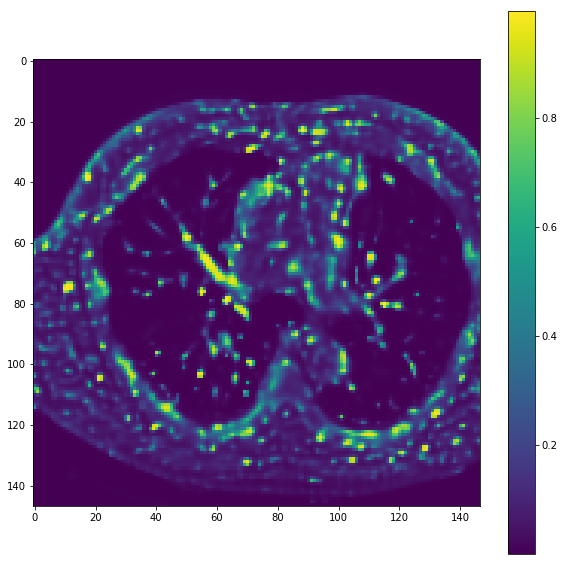

In [30]:
figure(figsize=(10,10))
imshow(full_result_p[60,:147,:147,1])
colorbar()

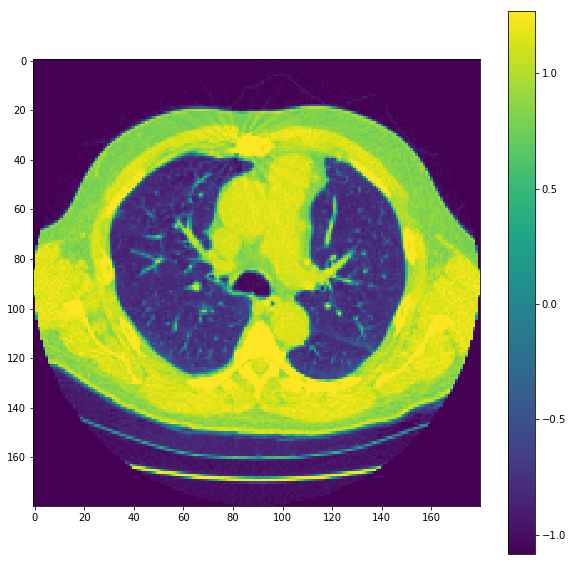

In [33]:
figure(figsize=(10,10))
imshow(image_h[60+8])
colorbar()

In [ ]:
patient_ids = data.luna16_get_patient_ids()
pid = [ x for x in patient_ids if in '5b41250' ][0]

In [59]:
image = np.load('5b412509bc40a3aeb3b5efef1fdfcfc9.npy', mmap_mode='r')
image = preprocess(image)

In [58]:
image.shape

(302, 360, 360)

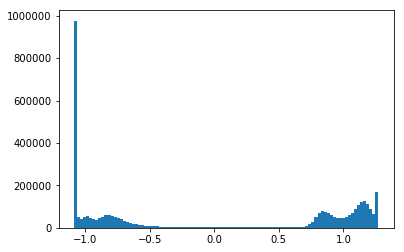

In [34]:
h = hist(image_h.ravel(), bins=100)

In [35]:
128 // 10

12